# Multi-Compartment Microscopic Diffusion Imaging

The recently proposed Multi-Compartment Microscopic Diffusion Imaging (MC-MDI) model *(Kaden et al. 2016)* is a spherical convolution-based technique, which separates intra- from extra-axonal diffusion inside the spherical convolution kernel as

$$
\begin{align}
\begin{aligned}
 E_{\textrm{MC-SMT}}= \overbrace{\operatorname{FOD}}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\,\left[\underbrace{f_r\overbrace{E_r(\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}+\underbrace{(1-f_r)\overbrace{E_h(\lambda_\parallel|\lambda_\perp^{\textrm{tort}})}^{\textrm{Zeppelin}}}_{\textrm{Hindered Extra-Axonal}}\right].
\end{aligned}
\end{align}$$

The formulation of MC-MDI finds similarities in models such as NODDI, but stands apart in only considering the spherical mean of the signal at every acquisition shell, as used in the Spherical Mean Technique (SMT) *(Kaden et al. 2015)*.

SMT observes that if the FOD is a probability density (i.e. integrated to unity) then spherical mean of the signal and the convolution kernel must be the same
\begin{equation}
\int_{\mathbb{S}^2}E_b(\textbf{g})d\textbf{g}=\int_{\mathbb{S}^2}(\operatorname{FOD}\,*_{\mathbb{S}^2}\,K)_b(\textbf{g})d\textbf{g}=\int_{\mathbb{S}^2}K_b(\textbf{g})d\textbf{g}=\epsilon_K(b,\lambda_\perp,\lambda_\parallel).
\end{equation}
The estimation of the multi-compartment kernel using SMT enables the characterization of per-axon micro-environments, as the effects of axon dispersion and crossings are only contained in the FOD.

Advantages:
- Insensitive to axon dispersion and crossings.

Limitations:
- Biased in the presence of non-white matter tissues (CSF)
- Only accounts for average of tissue properties in crossing configurations, which potentially each have different properties.
- Assumes Tortuosity constraint on perpendicular diffusivity.
- Assumes parallel diffusivity of intra- and extra-axonal compartments are the same.

# Using Dmipy to set up the MC-SMT Model
To set up the MC-MDI model in dmipy is straightforward. First, we call the basic Stick and Zeppelin components of the model:

In [1]:
from dmipy.signal_models import cylinder_models, gaussian_models
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()

Then we give these models as input for the MultiCompartmentSphericalMeanModel instance:

In [2]:
from dmipy.core import modeling_framework
mcdmi_mod = modeling_framework.MultiCompartmentSphericalMeanModel(
    models=[stick, zeppelin])
mcdmi_mod.parameter_names

['G2Zeppelin_1_lambda_perp',
 'C1Stick_1_lambda_par',
 'G2Zeppelin_1_lambda_par',
 'partial_volume_0',
 'partial_volume_1']

Calling MultiCompartmentSphericalMeanModel instead of MultiCompartmentModel will automatically fit the spherical mean of the model to the spherical mean of the signal, rather than the regular fitting of separate DWIs to the model.

Setting MC-MDI's tortuosity constraint and parallel diffusivity equality is the same as in the previous NODDI models.

In [3]:
mcdmi_mod.set_tortuous_parameter('G2Zeppelin_1_lambda_perp',
    'C1Stick_1_lambda_par','partial_volume_0', 'partial_volume_1')
mcdmi_mod.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')

In [4]:
mcdmi_mod.visualize_model_setup()

## Fitting MC-SMT to Human Connectome Project data

In [4]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()
sub_image = data_hcp[70:90,: , 70:90]

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


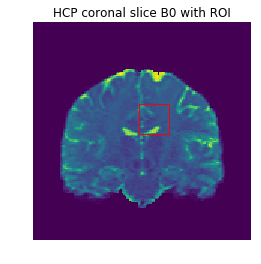

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

In [6]:
# Fitting a spherical mean model is again very fast.
mcdmi_fit_hcp = mcdmi_mod.fit(scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 1.49867081642 seconds
Fitting of 8181 voxels complete in 44.1347510815 seconds.
Average of 0.00539478683308 seconds per voxel.


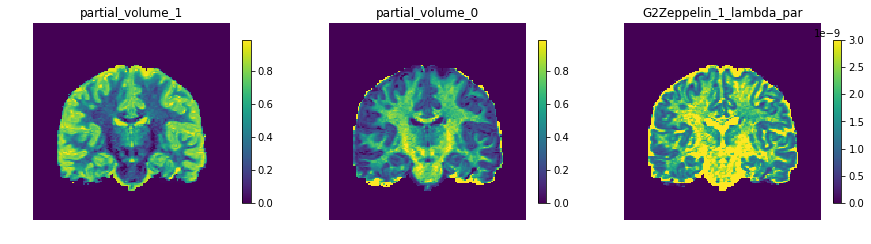

In [7]:
fitted_parameters = mcdmi_fit_hcp.fitted_parameters

fig, axs = plt.subplots(1, len(fitted_parameters), figsize=[15, 15])
axs = axs.ravel()

for i, (name, values) in enumerate(fitted_parameters.items()):
    cf = axs[i].imshow(values.squeeze().T, origin=True)
    axs[i].set_title(name)
    axs[i].set_axis_off()
    fig.colorbar(cf, ax=axs[i], shrink=0.2)

## Estimating Parametric FODs using Spherical Mean Kernel

Dmipy allows for the estimation of parametric Fiber Orientation Distributions (FODs) using the fitted spherical mean model parameters as a convolution kernel. At this time, it is possible to choose either 'watson' or 'bingham' distributions with any number of compartments.

For this example we fit two Watson distributions per voxel, which is similar to NODDIx. The difference is that we are not fitting an isotropic compartment now, but the diffusivities and volume fractions are the same for every bundle, are fixed, and are used as a convolution kernel.

\begin{align}
 E^{\textrm{MC-MDI
}}_{\textrm{2xWatson}}= \sum_{i=1}^{2}\overbrace{W(\kappa_i,\boldsymbol{\mu}_i)}^{\textrm{Watson}}\,*_{\mathbb{S}^2}\, \left[\underbrace{f_h\overbrace{E_{\textrm{h}}(\cdot|\lambda_\perp^{\textrm{tort}},\lambda_\parallel)}^{\textrm{Zeppelin}}}_{\textrm{Hindered Extra-Axonal}}+\underbrace{f_r\overbrace{E_r(\cdot|\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}\right].
\end{align}

### Watson FOD Estimation
First we fit MC-MDI on a patch where we want to estimate FODs.

In [8]:
mcmdi_csd_mod = mcdmi_fit_hcp.return_spherical_harmonics_fod_model()

In [23]:
mcmdi_csd_mod.visualize_model_setup()

In [9]:
mcmdi_csd_fit = mcmdi_csd_mod.fit(scheme_hcp, data_hcp, solver='tournier07', use_parallel_processing=False)

Setup Tournier07 FOD optimizer in 0.0104880332947 seconds
Fitting of 8181 voxels complete in 30.6163671017 seconds.
Average of 0.003742374661 seconds per voxel.


In [11]:
fods = mcmdi_csd_fit.fod(sphere.vertices)[70:90,: , 70:90]

Then we call for the FOD multi-compartment model that will allows us to fit the parametric FODs to the data.

In [9]:
parametric_fod_model = mcmdi_fit_patch.return_parametric_fod_model(
    distribution='watson', Ncompartments=2)

Notice that this returns a regular MultiCompartmentModel, with all the same solvers and options are available for FOD estimation. In this way, it is possible to have completely different approaches to estimating the kernel using a spherical mean model, and estimating the subsequent parametric FODs.

In [10]:
mcdmi_fod_fit = parametric_fod_model.fit(scheme_hcp, sub_image, solver='mix')

Using parallel processing with 8 workers.
Setup MIX optimizer in 8.10623168945e-06 seconds
Fitting of 400 voxels complete in 1583.12648392 seconds.
Average of 3.95781620979 seconds per voxel.


Fitting an FOD optimizer returns a FittedMultiCompartmentModel, where now all the same functions are available. We will show the estimated FODs in the next example.

### Watson FOD visualization

In [12]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724').subdivide()
# fods = mcdmi_fod_fit.fod(sphere.vertices, visual_odi_lower_bound=0.1)

In [18]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

volume_res = mcmdi_csd_fit.fitted_parameters['partial_volume_0'][70:90,: , 70:90]
volume_im = slicer(volume_res[:, 0, :, None], interpolation='nearest', affine=affine, opacity=0.7)

In [19]:
from dipy.viz import fvtk
ren = fvtk.ren()
# fod_spheres = fvtk.sphere_funcs(fods, sphere, scale=1., norm=False)
# fod_spheres.RotateX(90)
# fod_spheres.RotateZ(180)
# fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, volume_im)
fvtk.record(ren=ren, size=[700, 700])

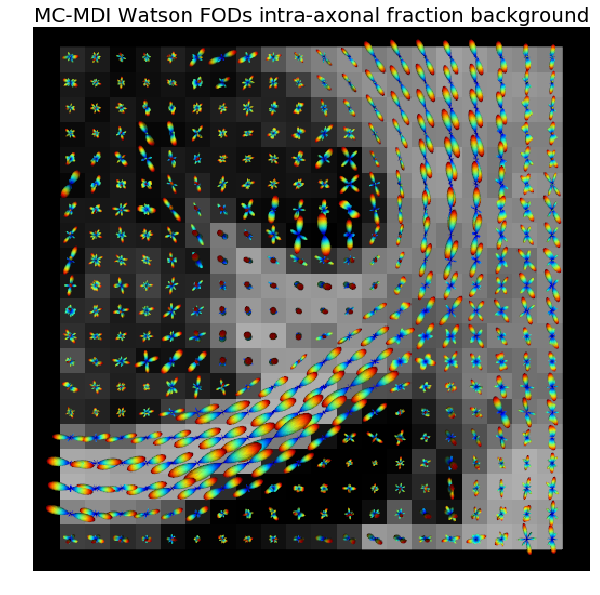

In [20]:
import matplotlib.image as mpimg
img = mpimg.imread('dipy.png')

plt.figure(figsize=[10, 10])
plt.imshow(img[100:-97, 100:-85])
plt.title('MC-MDI Watson FODs intra-axonal fraction background', fontsize=20)
plt.axis('off');

## Estimating Error Metrics: MSE and $R^2$

It is also possible to calculate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination.  
In MSE, the lower the better, while $R^2$ ranges between 0 and 1, with 1 being a perfect model fit.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/fitted_modeling_framework.py:317: RuntimeWarning: invalid value encountered in divide


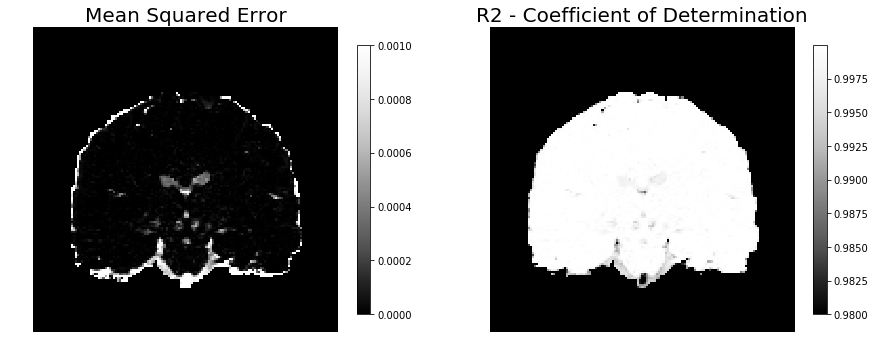

In [15]:
mse = mcdmi_fit_hcp.mean_squared_error(data_hcp)
R2 = mcdmi_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=1e-3, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
axs[0].set_axis_off()
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=.98, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20)
axs[1].set_axis_off();

The MSE shows that the fitting error is very low overall, with only slightly higher errors in the CSF and much larger errors in the skull. The $R^2$ agree with the MSE results, having values very close to 1 overall, with lower values in the CSF and skull.

## References
- Kaden, Enrico, et al. "Multi-compartment microscopic diffusion imaging." NeuroImage 139 (2016): 346-359.
- Kaden, Enrico, Frithjof Kruggel, and Daniel C. Alexander. "Quantitative mapping of the per‐axon diffusion coefficients in brain white matter." Magnetic resonance in medicine 75.4 (2016): 1752-1763.